In [64]:
import os
import numpy as np
import pandas as pd
from pandas import concat


file_USDEUR = 'Data/USDEUR.csv'
file_USICSAM = 'Data/USICSAM.csv'
file_EZ_CI = 'Data/Euro Area Consumer Confidence Index.csv'

time_series_USICSAM = pd.read_csv(file_USICSAM, sep=',', header=2, index_col=0, parse_dates=['Date'])
time_series_USDEUR = pd.read_csv(file_USDEUR, sep=',', header=2, index_col=0, parse_dates=['Date'])
time_series_EZ_CI = pd.read_csv(file_EZ_CI, sep=',', header=2, index_col=0, parse_dates=['Date'])

#we have to first pad missing values and then select dates otherwise dimensions don't match due to low frequency
time_series_USICSAM = time_series_USICSAM['Close'].resample('D').pad()['2001-01-01':'2020-12-31']  
time_series_USDEUR = time_series_USDEUR['Close'].resample('D').pad()['2001-01-01':'2020-12-31']
time_series_EZ_CI = time_series_EZ_CI['Close'].resample('D').pad()['2001-01-01':'2020-12-31']


print(type(time_series_EZ_CI))
print('Unemployment claims: \n', time_series_USICSAM)
print('\n Exchange rate: \n', time_series_USDEUR)
print('\n Eurozone Consumer Index: \n', time_series_EZ_CI)






<class 'pandas.core.series.Series'>
Unemployment claims: 
 Date
2001-01-01    353000
2001-01-02    353000
2001-01-03    353000
2001-01-04    353000
2001-01-05    353000
               ...  
2020-12-27    782000
2020-12-28    782000
2020-12-29    782000
2020-12-30    782000
2020-12-31    782000
Freq: D, Name: Close, Length: 7305, dtype: int64

 Exchange rate: 
 Date
2001-01-01    1.0613
2001-01-02    1.0531
2001-01-03    1.0775
2001-01-04    1.0537
2001-01-05    1.0441
               ...  
2020-12-27    0.8194
2020-12-28    0.8184
2020-12-29    0.8163
2020-12-30    0.8131
2020-12-31    0.8185
Freq: D, Name: Close, Length: 7305, dtype: float64

 Eurozone Consumer Index: 
 Date
2001-01-01    105.29250
2001-01-02    105.29250
2001-01-03    105.29250
2001-01-04    105.29250
2001-01-05    105.29250
                ...    
2020-12-27     98.38645
2020-12-28     98.38645
2020-12-29     98.38645
2020-12-30     98.38645
2020-12-31     98.61095
Freq: D, Name: Close, Length: 7305, dtype: float64


In [37]:
#concatenate values (i.e. w/o date) of series into a single array
print(np.shape(time_series_USICSAM.values))
ts = np.transpose(np.vstack((time_series_USDEUR.values, time_series_USICSAM.values, time_series_EZ_CI.values )))
print(np.shape(ts))

(7305,)
(7305, 3)


In [40]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# ensure all data is float
ts = ts.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict, i.e. USICSAM, EZ_CI at time t
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.767241   0.022802   0.978606  0.752815
2   0.752815   0.022802   0.978606  0.795742
3   0.795742   0.022802   0.978606  0.753870
4   0.753870   0.022802   0.978606  0.736981
5   0.736981   0.022802   0.978606  0.736981


In [67]:
values = reframed.values
print(values)

# split into train and test sets
values = reframed.values
n_train_days = 365 * 6
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.76724136 0.02280228 0.9786062  0.7528149 ]
 [0.7528149  0.02280228 0.9786062  0.7957424 ]
 [0.7957424  0.02280228 0.9786062  0.75387037]
 ...
 [0.33990157 0.08715872 0.50835943 0.3362068 ]
 [0.3362068  0.08715872 0.50835943 0.33057702]
 [0.33057702 0.08715872 0.50835943 0.3400774 ]]
(2190, 1, 3) (2190,) (5114, 1, 3) (5114,)


In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from matplotlib import pyplot 
from sklearn.metrics import mean_squared_error


# Hyperparameters and choices ... yet to be optimized
lr =1e-3
opt = keras.optimizers.Adam(learning_rate=lr)
ls = 'mse'  # 'mae'
bs = 72
epo = 250
hid_dim1 = 100


#model.add(Dropout(0.2, input_shape=(60,)))


# design network
model = Sequential()
model.add(LSTM(hid_dim1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss=ls, optimizer=opt)
# fit network
history = model.fit(train_X, train_y, epochs=epo, batch_size=bs, validation_data=(test_X, test_y), verbose=2, shuffle=False)




Epoch 1/250
31/31 - 2s - loss: 0.2346 - val_loss: 0.0310
Epoch 2/250
31/31 - 0s - loss: 0.1029 - val_loss: 0.0137
Epoch 3/250
31/31 - 0s - loss: 0.0457 - val_loss: 0.0262
Epoch 4/250
31/31 - 0s - loss: 0.0294 - val_loss: 0.0272
Epoch 5/250
31/31 - 0s - loss: 0.0255 - val_loss: 0.0242
Epoch 6/250
31/31 - 0s - loss: 0.0237 - val_loss: 0.0220
Epoch 7/250
31/31 - 0s - loss: 0.0215 - val_loss: 0.0199
Epoch 8/250
31/31 - 0s - loss: 0.0193 - val_loss: 0.0178
Epoch 9/250
31/31 - 0s - loss: 0.0171 - val_loss: 0.0158
Epoch 10/250
31/31 - 0s - loss: 0.0150 - val_loss: 0.0139
Epoch 11/250
31/31 - 0s - loss: 0.0129 - val_loss: 0.0121
Epoch 12/250
31/31 - 0s - loss: 0.0110 - val_loss: 0.0104
Epoch 13/250
31/31 - 0s - loss: 0.0092 - val_loss: 0.0088
Epoch 14/250
31/31 - 0s - loss: 0.0076 - val_loss: 0.0074
Epoch 15/250
31/31 - 0s - loss: 0.0061 - val_loss: 0.0062
Epoch 16/250
31/31 - 0s - loss: 0.0048 - val_loss: 0.0052
Epoch 17/250
31/31 - 0s - loss: 0.0037 - val_loss: 0.0043
Epoch 18/250
31/31 - 0s

31/31 - 0s - loss: 1.1701e-04 - val_loss: 0.0015
Epoch 135/250
31/31 - 0s - loss: 1.1735e-04 - val_loss: 0.0015
Epoch 136/250
31/31 - 0s - loss: 1.1773e-04 - val_loss: 0.0015
Epoch 137/250
31/31 - 0s - loss: 1.1817e-04 - val_loss: 0.0014
Epoch 138/250
31/31 - 0s - loss: 1.1867e-04 - val_loss: 0.0014
Epoch 139/250
31/31 - 0s - loss: 1.1924e-04 - val_loss: 0.0014
Epoch 140/250
31/31 - 0s - loss: 1.1988e-04 - val_loss: 0.0014
Epoch 141/250
31/31 - 0s - loss: 1.2057e-04 - val_loss: 0.0013
Epoch 142/250
31/31 - 0s - loss: 1.2130e-04 - val_loss: 0.0013
Epoch 143/250
31/31 - 0s - loss: 1.2204e-04 - val_loss: 0.0013
Epoch 144/250
31/31 - 0s - loss: 1.2276e-04 - val_loss: 0.0012
Epoch 145/250
31/31 - 0s - loss: 1.2342e-04 - val_loss: 0.0012
Epoch 146/250
31/31 - 0s - loss: 1.2398e-04 - val_loss: 0.0012
Epoch 147/250
31/31 - 0s - loss: 1.2439e-04 - val_loss: 0.0012
Epoch 148/250
31/31 - 0s - loss: 1.2461e-04 - val_loss: 0.0011
Epoch 149/250
31/31 - 0s - loss: 1.2463e-04 - val_loss: 0.0011
Epoch 

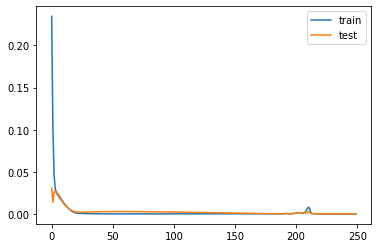

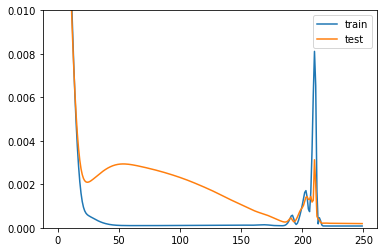

In [76]:
# plot history for loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.ylim([0,0.001])
pyplot.legend()
pyplot.show()
